# Task

You are given a set of images that are classified by a model trained on Imagenet as goldfish (class 1). Your task is to compute a strip of pixels of size
10 x 100 (i.e., the first 10 rows of an image of size 100 x 100), which when pasted into *each* of the original images makes the model think it is a shark (class 2) with returned probability of at least 0.5.

Note: you can score half of the points in this task if you compute a strip that works for at least one image from the list.

Important: your code needs to compute the desired strip in at most 2 minutes - it is possible to do it in less than 10 seconds on colab with GPU.


## Data

Below you can find a piece of code that download a zipfile and displays the images. Note that here the images are in their original resolution that will be later scaled down to 100 x 100.

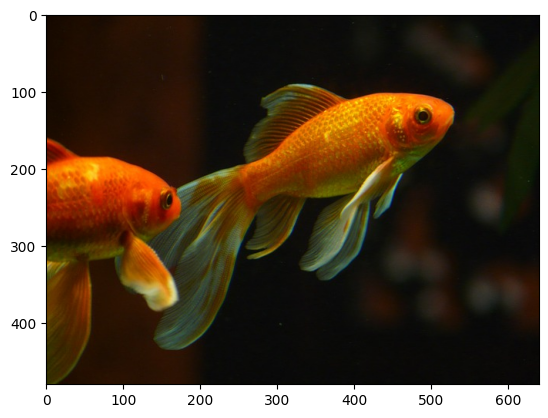

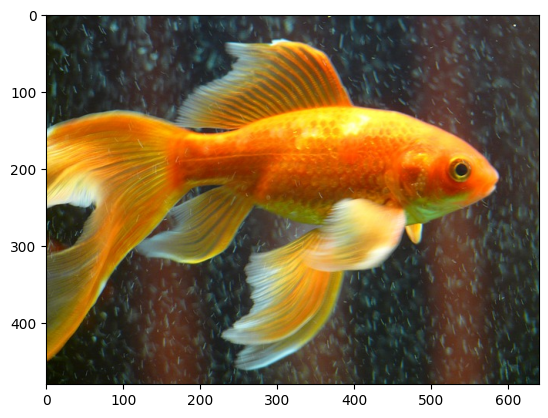

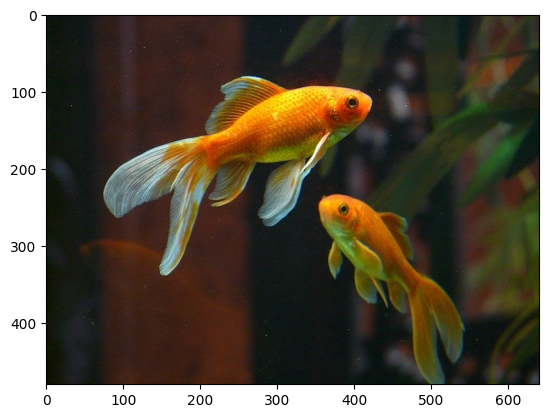

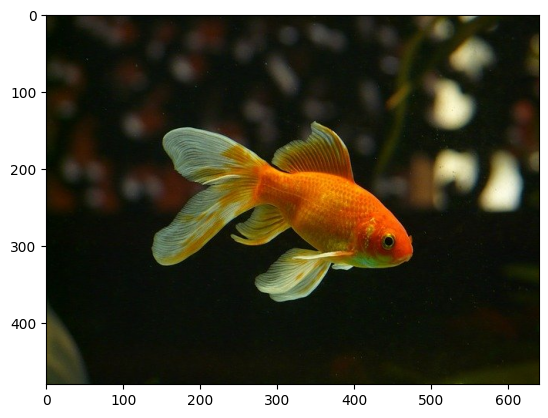

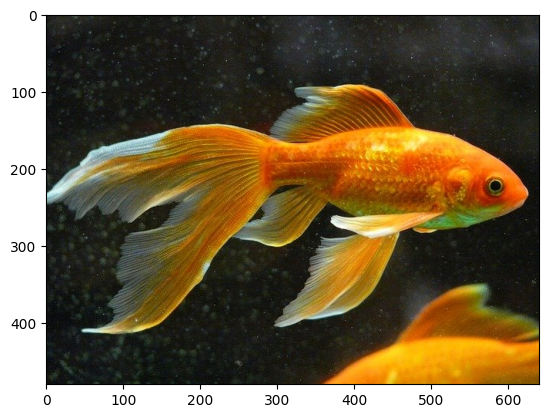

In [1]:
import requests, zipfile
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

url = "https://www.mimuw.edu.pl/~cygan/goldfish.zip"
request = requests.get(url)
zipfile = zipfile.ZipFile(BytesIO(request.content))
images = []
for filename in zipfile.namelist():
  if filename.endswith('jpg'):
    ifile = zipfile.open(filename)
    img = Image.open(ifile)
    images.append(img)
    plt.imshow(img)
    plt.show()


## Model

We will be using the `mobilenet_v2` model, solving the classification problem on the Imagenet dataset. As far as this task is concerned you do not have to know the details of the model's architecture, we are treating it as a black box, in particular the model's weights will be frozen and cannot be changed.



In [2]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import numpy as np
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


cuda:0


100%|██████████| 13.6M/13.6M [00:00<00:00, 72.5MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Data preprocessing

In order to evaluate the model on the given images, we first scale them down to size 100x100 (which is an arbitrary choice selected for this task), but also normalize them using the following normalization transform.


In [3]:
normalize_colors = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])

SIZE = 100
resize = transforms.Compose([transforms.Resize((SIZE, SIZE)),
                             transforms.ToTensor()])

## Evaluation

Below is a piece of code that takes an input a given image and a tensor of size 3x10x100 with values between 0 and 1, and:
* rescales the image to size 100x100,
* replaces the first chunk of size 10x100 by the given tensor (for all 3 colors),
* normalizes the colors of the obtained image,
* evaluates the model and returns the probabilities of the image being classified as goldfish and shark respectively.

In [4]:
STRIP_HEIGHT = 10

def calc_predictions(image, strip):
  assert strip.shape == (3, STRIP_HEIGHT, SIZE)
  assert torch.ge(strip, 0.).all()
  assert torch.le(strip, 1.0).all()
  img_tensor = resize(image.convert("RGB")).to(device)
  # At this point img_tensor is of shape (3, SIZE, SIZE)
  ############# Important line - replacing part of the image ################
  img_tensor[:, :STRIP_HEIGHT, :] = strip.to(device)
  img_tensor = normalize_colors(img_tensor)
  # We have to add one more dimention representing the bath.
  img_tensor = img_tensor.unsqueeze(0)
  probabilities = torch.nn.functional.softmax(model(img_tensor)[0], dim=-1)
  # Class 1 in Imagenet is a goldfish, 2 is a shark
  return probabilities[1], probabilities[2]

In [5]:
for im in images:
  p_goldfish, p_shark = calc_predictions(im, torch.zeros((3, STRIP_HEIGHT, SIZE)))
  print(f'Probability of being a goldfish is {p_goldfish}, shark is {p_shark}.')

Probability of being a goldfish is 0.9991118311882019, shark is 9.153793174843106e-12.
Probability of being a goldfish is 0.9996259212493896, shark is 6.371178541339506e-13.
Probability of being a goldfish is 0.9545308351516724, shark is 2.641739951791955e-11.
Probability of being a goldfish is 0.9552140831947327, shark is 2.3239125467727773e-12.
Probability of being a goldfish is 0.9978418350219727, shark is 2.3563741019180795e-13.


## TO IMPLEMENT

Here you have to implement the function that finds the strip. Please don't modify the name of the function, as later it will be automatically tested.


epoch 0


<ipython-input-11-ba2032e7d3c6>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = -torch.nn.functional.log_softmax(pred)[2]


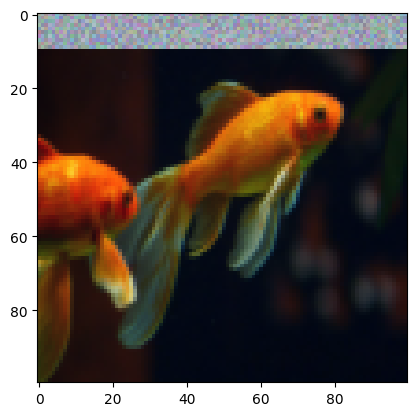

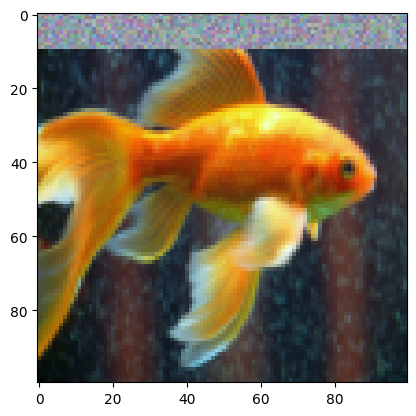

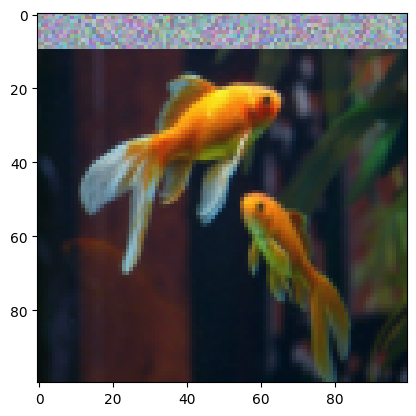

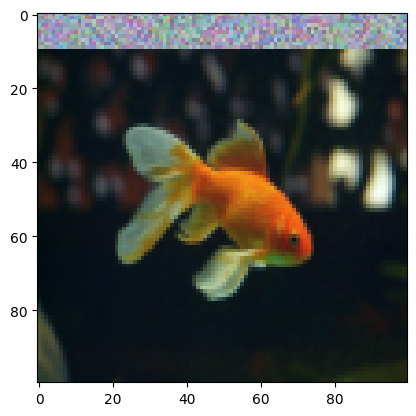

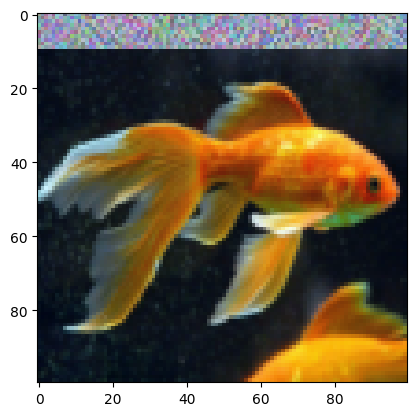

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10


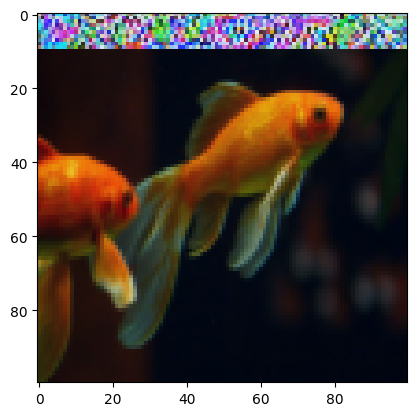

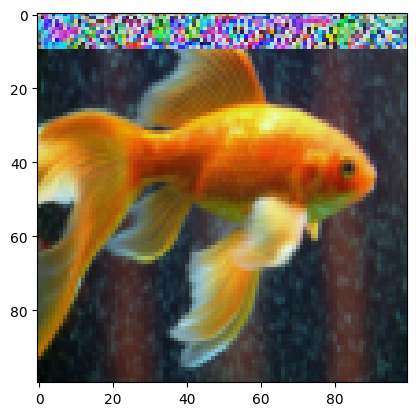

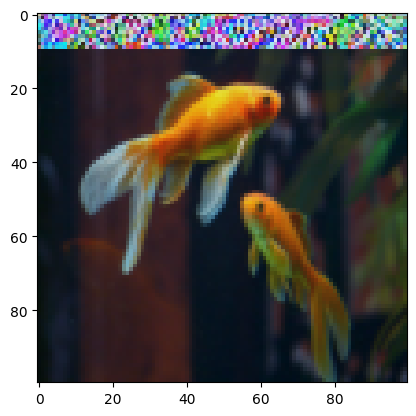

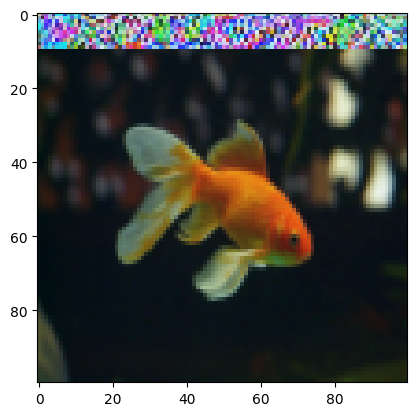

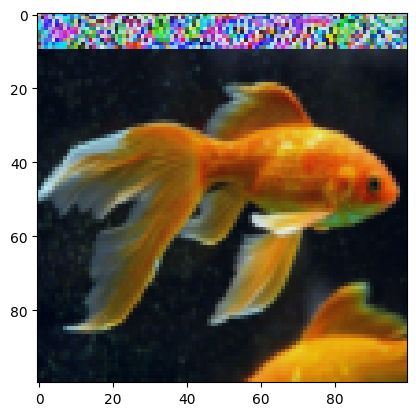

epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20


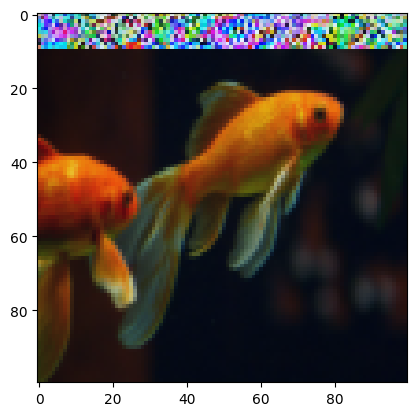

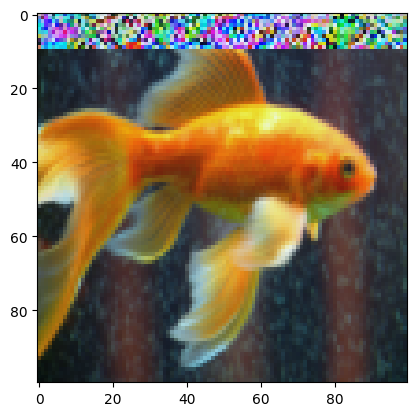

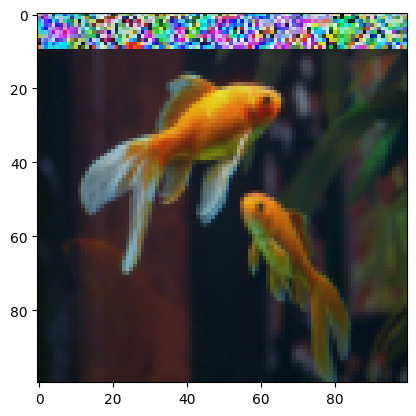

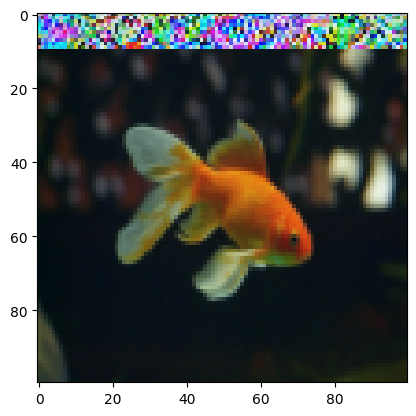

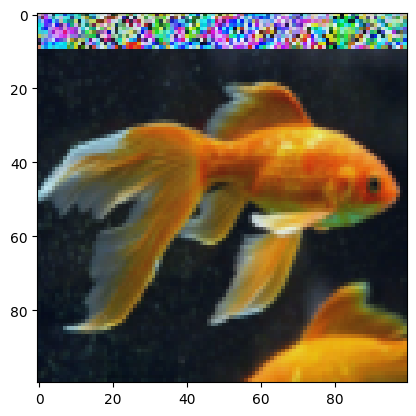

epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30


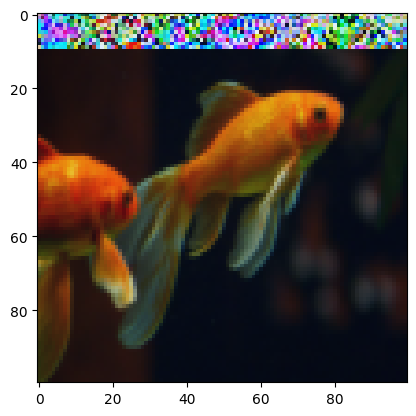

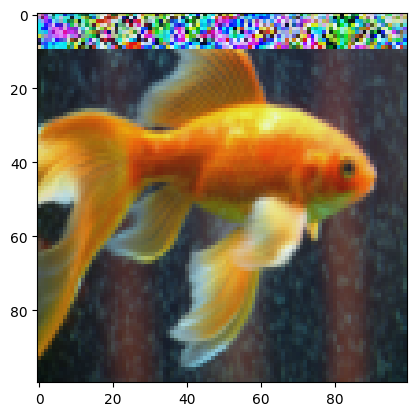

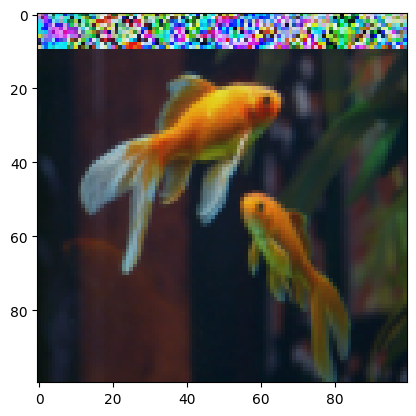

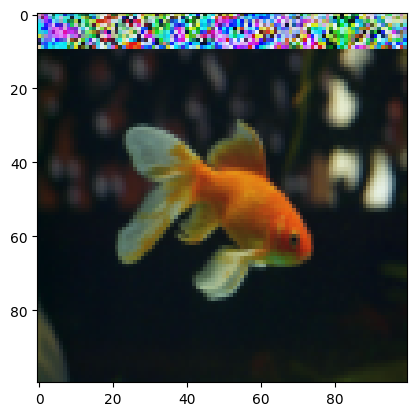

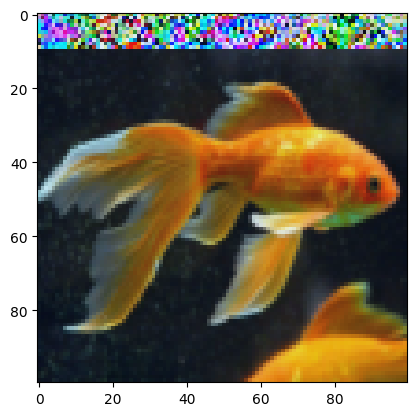

epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40


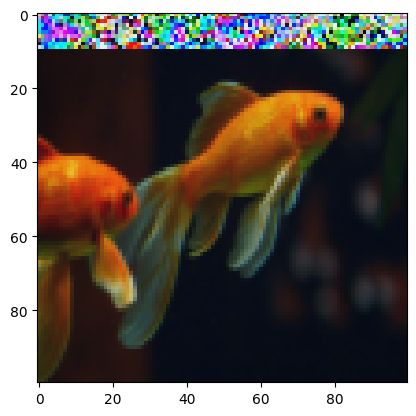

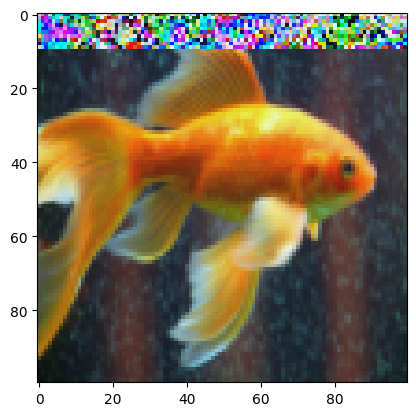

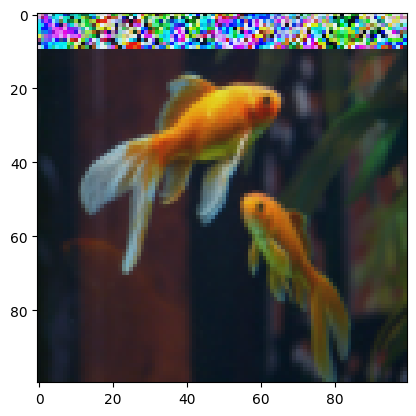

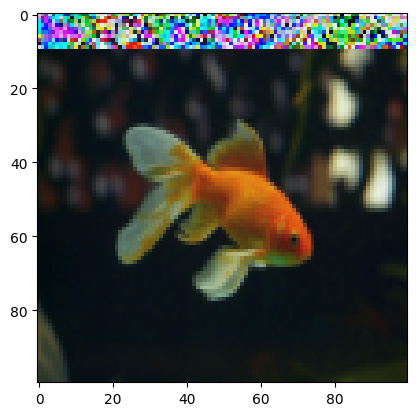

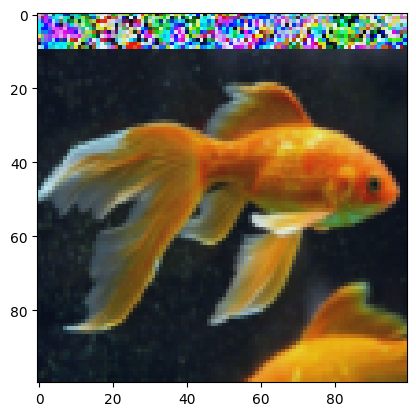

epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50


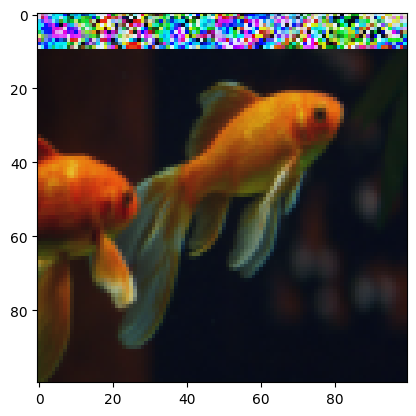

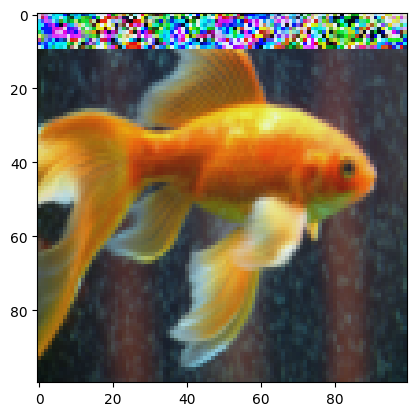

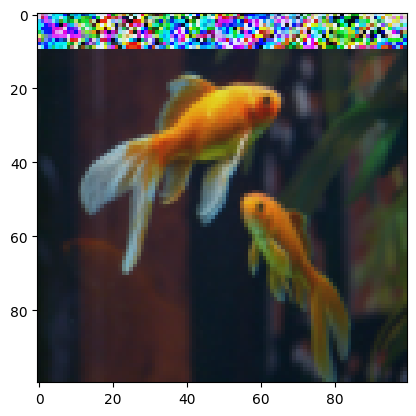

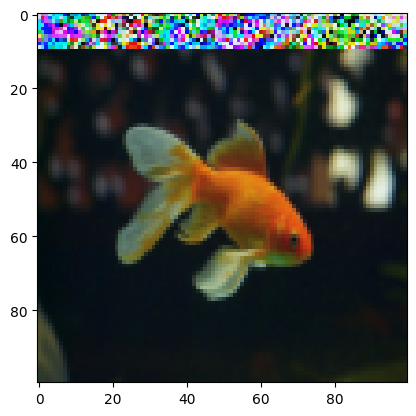

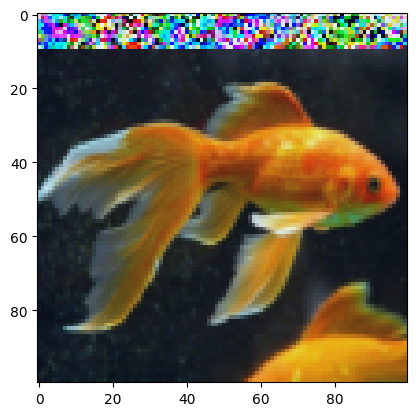

epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60


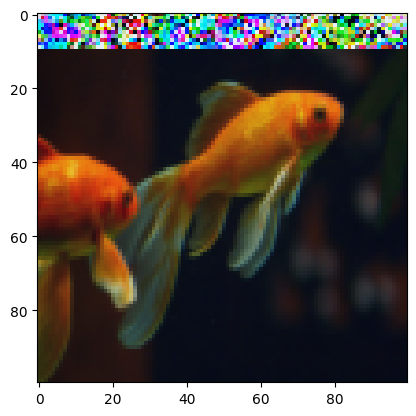

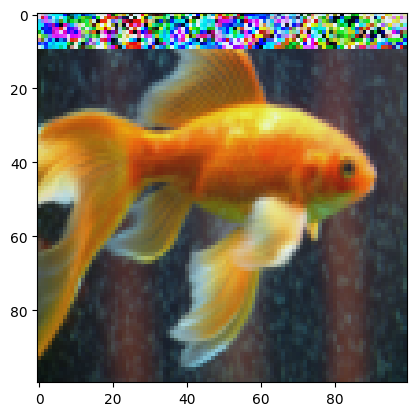

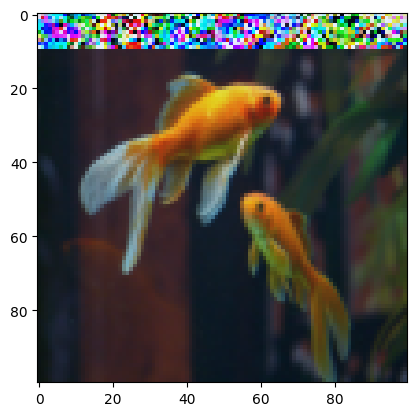

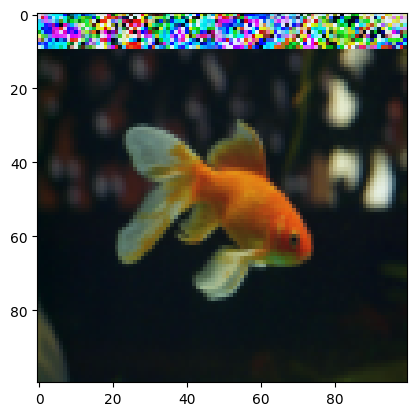

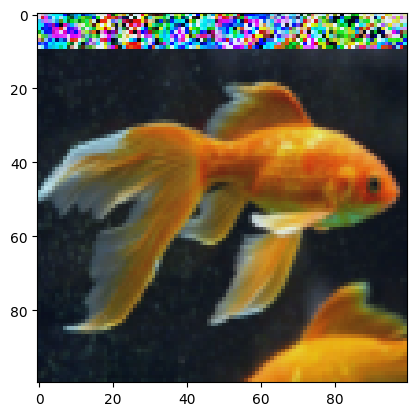

epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70


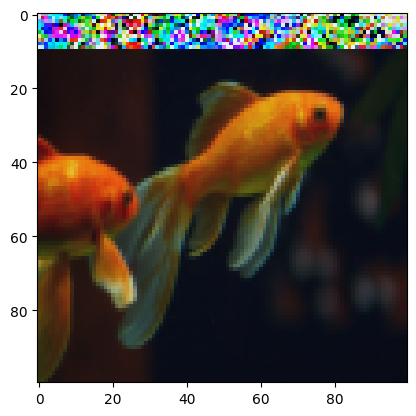

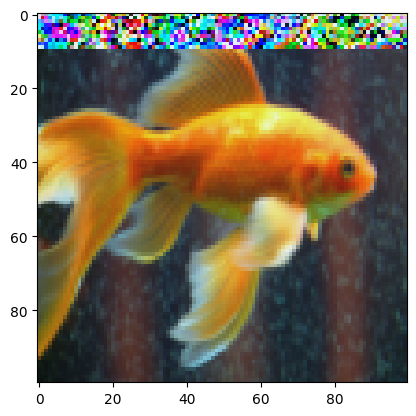

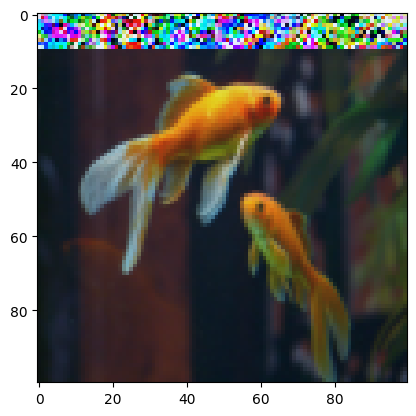

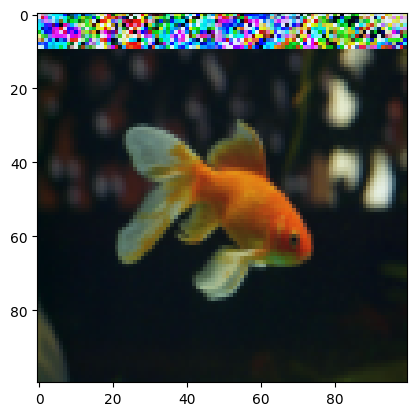

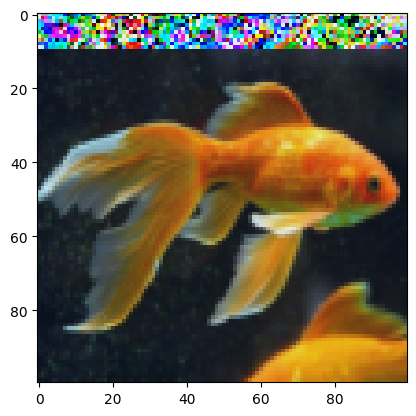

epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80


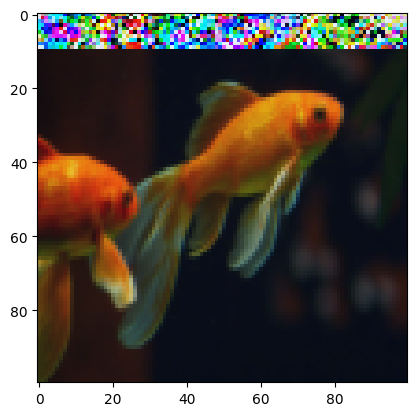

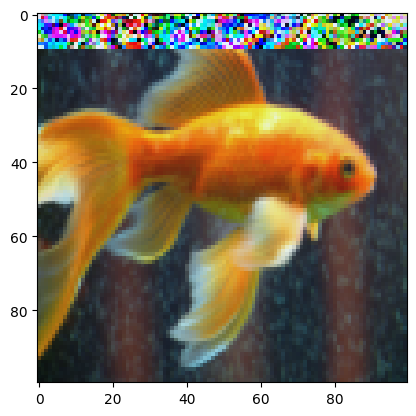

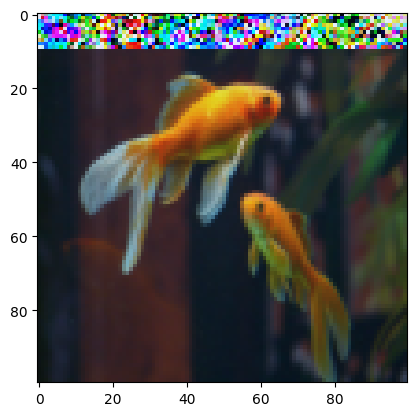

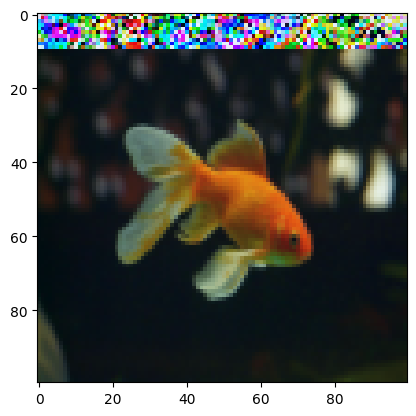

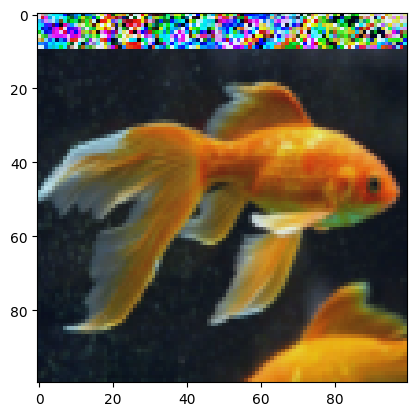

epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90


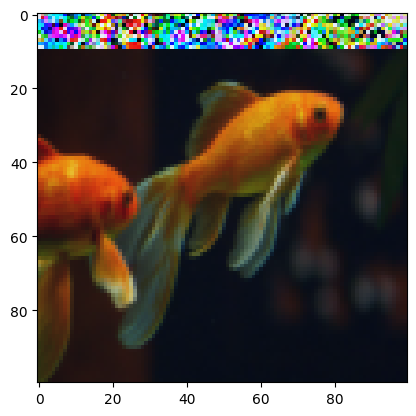

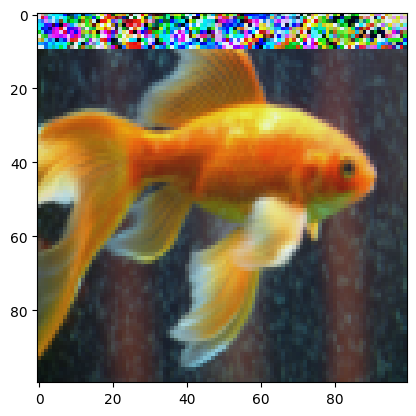

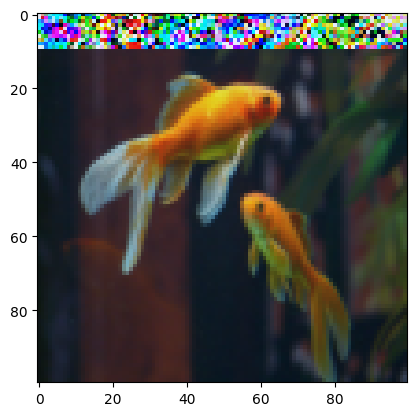

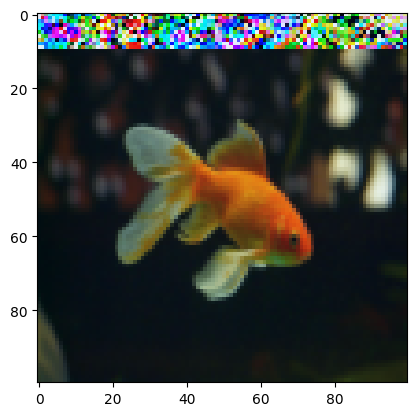

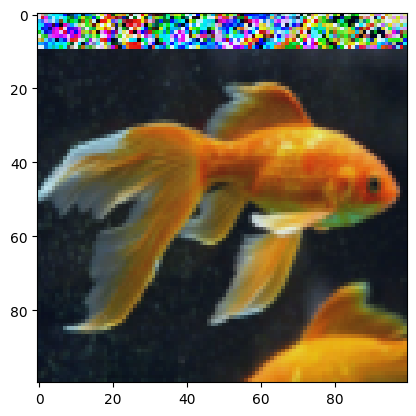

epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
Probability of being a goldfish is 0.0019408401567488909, shark is 0.9187349677085876.
Probability of being a goldfish is 0.13518762588500977, shark is 0.6739709973335266.
Probability of being a goldfish is 0.0012623290531337261, shark is 0.867290735244751.
Probability of being a goldfish is 0.0009152185521088541, shark is 0.695838451385498.
Probability of being a goldfish is 0.35344570875167847, shark is 0.029945166781544685.


In [11]:
def calculate_strip():
  ## TODO
  param = torch.rand((3, STRIP_HEIGHT, SIZE), requires_grad=True, device=device)
  optimizer = torch.optim.Adam([param], lr=0.1)
  for epoch in range(100):
    print(f'epoch {epoch}')
    losses = []
    for im in images:
        optimizer.zero_grad()
        img_tensor = resize(im.convert("RGB")).to(device)
        img_tensor[:, :STRIP_HEIGHT, :] = torch.nn.functional.sigmoid(param)
        img_tensor = normalize_colors(img_tensor)
        img_tensor = img_tensor.unsqueeze(0)

        pred = model(img_tensor)[0]
        loss = -torch.nn.functional.log_softmax(pred)[2]
        losses.append(loss.detach())
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
          img_tensor_c = img_tensor.detach().cpu()
          img_tensor_c -= img_tensor_c.min()
          img_tensor_c /= img_tensor_c.max()
          plt.imshow(img_tensor_c[0].permute(1, 2, 0))
          plt.show()
  return torch.nn.functional.sigmoid(param)


strip = calculate_strip()
for im in images:
  p_goldfish, p_shark = calc_predictions(im, strip)
  print(f'Probability of being a goldfish is {p_goldfish}, shark is {p_shark}.')